In [59]:
# This notebook was written for Python 3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import scipy.stats as stats
import scipy.optimize
import re

%matplotlib inline

In [60]:
blues = sns.color_palette('Blues', 9)
reds = sns.color_palette('Reds', 9)
greens = sns.color_palette('Greens', 9)
oranges = sns.color_palette('Oranges', 9)
grays = sns.color_palette('Greys', 9)
purples = sns.color_palette('Purples', 9)
prs = sns.color_palette('PRGn', 9)
tanteals = sns.color_palette('BrBG', 9)
pinkgreens = sns.color_palette('PiYG', 9)[::-1]


bw = {'axis.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white',
     'grid.color': 'white', 'axes.edgecolor': 'white', 'axes.facecolor': 'black',
     'text.color': 'white', 'axes.labelcolor': 'white', 'figure.facecolor' : 'black',
     'xtick.major.size': 5.0, 'xtick.minor.size': 5.0, 
      'ytick.major.size': 5.0, 'ytick.minor.size': 5.0, 'axes.linewidth': 1.0}
bw_tickless = {'axis.labelcolor': 'white', 'grid.color': 'white', 
               'axes.edgecolor': 'white', 'axes.facecolor': 'black', 'text.color': 'white', 
               'axes.labelcolor': 'white', 'figure.facecolor' : 'black', 'axes.linewidth': 1.0,
              'xtick.color': 'white', 'ytick.color': 'white'}

## Import growth rates

In [61]:
df = pd.read_csv('raw/microcolony_growth.csv', delimiter = ',')

In [62]:
df.head()
df.tail()
df.sample(n = 5)

,Gomp_12h,N0_linear,Gomp_4h,r2_growthrate2,Gomp_8h,growthrate2,Gomp_6h,growthrate1,Gomp_10h,r2_growthrate1,t_graphical
32,0.100953,12854.666667,0.020458,NaN,0.057806,NaN,0.037258,0.011035,0.079749,0.996721,NaN
86,0.972558,18455.666667,0.007893,0.993515,0.257982,0.004488,0.068204,0.011838,0.586174,0.998387,409.769238
74,1.712461,19455.000000,0.182892,0.999426,0.819461,0.005192,0.441673,0.010694,1.263875,0.998503,247.456032
18,NaN,21428.000000,NaN,NaN,NaN,NaN,NaN,0.011320,NaN,0.998419,NaN
75,1.248642,19311.333333,0.045097,0.997998,0.429756,0.005140,0.171484,0.011117,0.808474,0.997692,371.586026


In [63]:
# These columns above refer to:
# N0_linear: the 2D area of the microcolony at the time of glucose withdrawal, in px. Linear/not log.
# growthrate1: the doubling rate/min pre-starvation as calculated by fitting an exponential curve 
# growthrate2: the doubling rate/min post-starvation as calcuated by fitting an exponential curve; NaN = no growth
# r2_growthrate1, r2_growthrate2: the r^2 for the fits for growthrate1 and growthrate2, respectively
# Gomp_Nh: the natural log fold change in 2D area by N hr post-starvation, i.e. ln(N(t)/N(0))
# t_graphical: the lag time in min calculated as the intersection of the straight line at N0_linear 
#          and the log of the exponential fit used in growth rate calculations; NaN = no growth resumption

/Users/laurabagamery/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


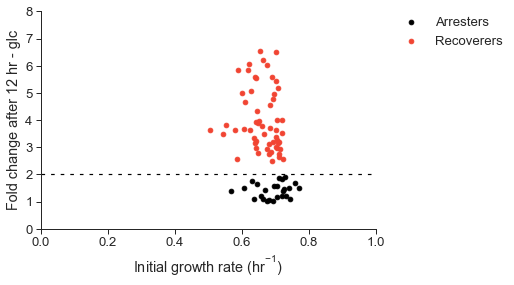

In [64]:
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')

df_reals = df[df['Gomp_12h'] != 'NaN']
df_12h_arresters = df_reals[df_reals['Gomp_12h'] <= np.log(2)]
#df_12h_recoverers = df_reals[df_reals['Gomp_12h'] >= np.log(2)]
df_12h_recoverers = df_reals[df_reals['Gomp_12h'] > np.log(2) + 0.01]



f, ax = plt.subplots()

plt.scatter(df_12h_arresters['growthrate1']*60, np.exp(df_12h_arresters['Gomp_12h'].astype(float)),
            color = 'black', label = 'Arresters')
plt.scatter(df_12h_recoverers['growthrate1']*60, np.exp(df_12h_recoverers['Gomp_12h'].astype(float)),
                                                    color = reds[5], label = 'Recoverers')


plt.axhline(y = 2, color = 'black', linestyle = (0, (3,5)))



ax.set_xlim(0, 1)
ax.set_ylim(0, 8)
ax.set_xlabel('Initial growth rate ($\mathregular{hr^{-1}}$)')
ax.set_ylabel('Fold change after 12 hr - glc')

ax.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0, frameon = False);

sns.despine()

/Users/laurabagamery/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/laurabagamery/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


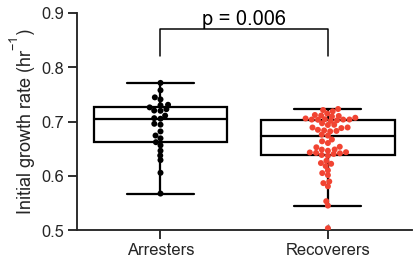

In [65]:
sns.set_context('talk')
sns.set_style('ticks')

f, ax = plt.subplots()

df_12h_arresters.loc[:, 'phenotype'] = 'Arresters'
df_12h_recoverers.loc[:, 'phenotype'] = 'Recoverers'
df_12h_all = pd.concat([df_12h_arresters, df_12h_recoverers])
df_12h_all['growthrate1'] = df_12h_all['growthrate1']*60

sns.boxplot(x = 'phenotype', y = 'growthrate1', data = df_12h_all, color = 'white')
sns.swarmplot(x = 'phenotype', y = 'growthrate1', data = df_12h_all, palette = ['black', reds[5]],
             size = 6)

[x1, x2] = [0, 1]
[y, h, col] = [df_12h_all['growthrate1'].max() + 0.05, 0.05, 'black']
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw = 1.5, c = col)
plt.text((x1 + x2)/2, y + h, 'p = 0.006', ha = 'center', va = 'bottom', color = col, fontsize = 20)



ax.set_ylim(0.5, 0.9)
ax.set_xlabel('')
ax.set_ylabel('Initial growth rate ($\mathregular{hr^{-1}}$)')

plt.setp(ax.artists, edgecolor = 'black', facecolor='white')
plt.setp(ax.lines, color='black')

sns.despine()



In [66]:
stats.mannwhitneyu(df_12h_arresters['growthrate1'], 
                   df_12h_recoverers['growthrate1'], alternative = 'two-sided')

MannwhitneyuResult(statistic=985.0, pvalue=0.0061483440004506005)

In [67]:
print(len(df_12h_all))

82
